In [2]:
%matplotlib inline
import spikeinterface as si
import spikeinterface.widgets as sw
from pathlib import Path
import os

import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.curation as scur

# recompute qc
from spikeinterface.qualitymetrics.misc_metrics import isi_violations, presence_ratio, amplitude_cutoff
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

import json

from scipy.stats import pearsonr
from scipy.stats import gaussian_kde

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import seaborn as sns
from sklearn.model_selection import LeaveOneOut
import statsmodels.api as sm
from statsmodels.genmod.families import Binomial, Gaussian
from statsmodels.genmod.families.links import logit, Log, Identity
from utils.beh_functions import parseSessionID, session_dirs

In [5]:
session = 'behavior_751004_2024-12-23_14-20-03'
session_dir = session_dirs(session)

In [52]:
# load extract features
num_peak_channels = 2
num_peak_pc = 2
outfolder = Path(f'/root/capsule/scratch/features/{session}')
pc_feature = np.load(outfolder / 'pc_feature.npy')
pc_feature_ind = np.load(outfolder / 'pc_feature_ind.npy')
spike_clusters = np.load(outfolder / 'spike_clusters.npy')
spike_templates = np.load(outfolder / 'spike_templates.npy')
spike_times = np.load(outfolder / 'spike_times.npy')  

In [53]:
raw_dir = f'/root/capsule/data/{session}'
stream_name = 'experiment1_Record Node 104#Neuropix-PXI-100.ProbeA_recording1'
data_folder = '/root/capsule/data'
for dir in os.listdir(data_folder):
    if (session in dir) and ("sorted" in dir) and ("curated" in dir):
        curated_sorting_dir = f'{data_folder}/{dir}'
        break
curated_folder = curated_sorting_dir + '/curated/' + stream_name
postprocessed_folder = curated_sorting_dir + '/postprocessed/' + stream_name

In [54]:
def qm_simple_sorting(sorting, timestamps, sample_rate=30000, bin_duration_s=60, mean_fr_ratio_thresh=0.01):
    unit_ids = sorting.get_unit_ids()
    isi_violations_ratio = [None]*len(unit_ids)
    isi_violations_rate = [None]*len(unit_ids)
    isi_violations_count = [None]*len(unit_ids)
    presence_ratio_qc = [None]*len(unit_ids)
    firing_rate = [None]*len(unit_ids) 
    recLength = timestamps[-1] - timestamps[0]
    bin_edges = np.arange(timestamps[0], timestamps[-1], bin_duration_s)


    for unitInd, unit_id in enumerate(unit_ids):
        timestampsCurr = timestamps[sorting.get_unit_spike_train(unit_id)]
        # isi_v
        isi_violations_ratio[unitInd], isi_violations_rate[unitInd], isi_violations_count[unitInd] = isi_violations([timestampsCurr], recLength, isi_threshold_s=0.0015, min_isi_s=1/sample_rate)
        # presence ratio
        unit_fr = len(timestampsCurr)/recLength
        bin_n_spikes_thres = np.floor(unit_fr * bin_duration_s * mean_fr_ratio_thresh)
        presence_ratio_qc[unitInd] = presence_ratio(timestampsCurr, recLength, bin_edges=bin_edges, bin_n_spikes_thres=bin_n_spikes_thres)
        # firing rate
        firing_rate[unitInd] = unit_fr

    qm = pd.DataFrame({
                    'unit_id': unit_ids,
                    'isi_violations_ratio': isi_violations_ratio,
                    'presence_ratio': presence_ratio_qc,
                    'firing_rate': firing_rate})
    return qm       

In [55]:
def load_and_preprocess_recording(raw_data_folder, stream_name):
    compressed_folder = raw_data_folder + "/ecephys_compressed/"
    raw_stream_name = stream_name[:stream_name.find("_recording")]
    recording = si.read_zarr(compressed_folder+f"{raw_stream_name}.zarr")
    # preprocess
    recording_processed = spre.phase_shift(recording)
    recording_processed = spre.highpass_filter(recording_processed)    
    recording_processed = spre.common_reference(recording_processed)
    return recording_processed

In [56]:
def load_qm(sorting_dir):
    qm_dir = sorting_dir + '/postprocessed'
    for root, dirs, files in os.walk(qm_dir):
        # Check if 'quality' folder is in the current directory
        if 'quality_metrics' in dirs:
            quality_folder_path = os.path.join(root, 'quality_metrics')
            print(quality_folder_path)
            break
    
    if 'quality_folder_path' in locals(): 
        qm_file = os.path.join(quality_folder_path, 'metrics.csv')
        qm = pd.read_csv(qm_file, index_col=0)
        return qm
    else:
        print('No quality metrics folder found.')


Load

In [57]:
# load timestamps
timestamps_file = Path(raw_dir + '/ecephys_clipped/Record Node 104/experiment1/recording1/continuous/Neuropix-PXI-100.ProbeA/timestamps.npy')
if Path.exists(timestamps_file):
    timestamps = np.load(timestamps_file)
else:
    timestamps_file = Path(raw_dir + '/ecephys/ecephys_clipped/Record Node 104/experiment1/recording1/continuous/Neuropix-PXI-100.ProbeA/timestamps.npy')
    timestamps = np.load(timestamps_file)

# load sorting
sorting = si.load_extractor(curated_folder)

# load qm
qm = load_qm(curated_sorting_dir)

/root/capsule/data/behavior_717121_2024-06-15_10-00-58_sorted-curated_2024-07-25_06-45-59/postprocessed/experiment1_Record Node 104#Neuropix-PXI-100.ProbeA_recording1/quality_metrics


In [58]:
# sorting
counts = np.array(list(sorting.count_num_spikes_per_unit().values()))
unit_ids = sorting.unit_ids
labels = sorting.get_property('decoder_label')

# # recalculate qm
# sample_rate = 30000
# bin_duration_s = 60.0
# mean_fr_ratio_thresh = 0.01
# qm_simple = qm_simple_sorting(sorting, timestamps)

pass_qc = (qm['isi_violations_ratio']<0.1) & (qm['firing_rate']>0.1) & (qm['presence_ratio']>0.95) & (qm['amplitude_cutoff']<0.1) & (labels!='noise') & (labels!='artifact')
pass_qc = pass_qc.values
pass_real = (labels!='noise') & (labels!='artifact')
print(f'{np.sum(pass_qc)} out of {len(pass_qc)} units pass qc.')
print(f'{np.sum(pass_real)} out of {len(pass_qc)} units are real neurons.')

23 out of 243 units pass qc.
134 out of 243 units are real neurons.


In [59]:
# load we
we = si.load_waveforms(postprocessed_folder, with_recording=False)
sparsity = we.sparsity
unit_id_to_channel_ids = sparsity.unit_id_to_channel_ids

In [60]:
def get_features(unit_id, pc_feature, spike_clusters):
    spike_inds = np.where(spike_clusters == unit_id)[0]
    template = we.get_template(unit_id)
    # top channels
    peaks = np.min(template, axis=0)
    select_inds = np.argsort(peaks)[:num_peak_channels]
    # select pc
    pcs = pc_feature[spike_inds][:, :num_peak_pc, select_inds]
    return pcs

In [61]:
# # separate data into training and testing
# amps = we.load_extension("spike_amplitudes").get_data(outputs="by_unit")[0]
# locations = we.load_extension('unit_locations').get_data(outputs="by_unit")
# num_peak_channels = 2
# num_peak_pc = 2
# # detect drift by firing rate and amplitude
# # get spike trains into a dictionary
# spike_trains = {}
# segment_index = 60
# bin_size = 120
# bins = np.arange(timestamps[0], timestamps[-1], bin_size)
# time_long = 0.5*(bins[:-1] + bins[1:])
# mean_fr = []
# mean_amp = []
# mean_amp_mode = []
# mean_fr_mode = []
# pred_train = []
# pred_test = []
# fr_train = []
# fr_test = []
# R2_train = []
# R2_test = []
# train_mask = np.full(len(bins)-1, False)
# train_ind = np.arange(0, len(bins)-1, 2)
# train_mask[train_ind] = True
# time_long_test = time_long[~train_mask]
# time_long_train = time_long[train_mask]
# for unit_ind, unit_id in enumerate(unit_ids):
#     timestamps_curr = timestamps[sorting.get_unit_spike_train(unit_id)]
#     amplitude_curr = amps[unit_id]
#     # load pcs
#     pcs = get_features(unit_id, pc_feature, spike_clusters)
#     pcs = pcs.reshape(pcs.shape[0], -1)
#     pcs_median = np.median(pcs, axis=0)
#     pcs = np.abs(pcs - pcs_median)

#     bin_indices = np.digitize(timestamps_curr, bins)
#     fr_curr = np.zeros(len(bins)-1)
#     amp_curr = np.full(len(fr_curr), np.nan)
#     pc_curr = np.full((len(fr_curr), pcs.shape[1]), np.nan)
#     for bin_ind in range(len(fr_curr)):
#         fr_curr[bin_ind] = np.sum(bin_indices == (bin_ind+1))
#         if np.sum(bin_indices == (bin_ind+1)) > 0:
#             amp_curr[bin_ind] = np.nanmean(amplitude_curr[bin_indices == (bin_ind+1)])
#             pc_curr[bin_ind] = np.nanmean(pcs[bin_indices == (bin_ind+1)], axis=0)
#     amp_curr_dis = amp_curr-np.median(amp_curr)
    
#     # mean of amplitude
#     mean_amp_mode.append(np.median(amp_curr))
 
#     # mean of firing rate
#     mean_fr_mode.append(len(timestamps_curr)/(timestamps[-1]-timestamps[0]))
    
#     mean_fr.append(fr_curr/bin_size)
#     mean_amp.append(amp_curr)

#     # fit linear model on training data
#     # leave one out cross validation

#     mask = ~np.isnan(amp_curr)
#     lm = LinearRegression()
#     x_matrix = pc_curr
#     lm.fit(x_matrix[mask&train_mask,:], fr_curr[mask&train_mask]/bin_size)

#     # predict training data
#     pred = lm.predict(x_matrix[mask&train_mask,:])
#     pred_train_curr = np.full(np.sum(train_mask), np.nan)
#     pred_train_curr[mask[train_mask]] = pred
#     R2_train.append(r2_score(fr_curr[mask&train_mask]/bin_size, pred))

#     # predict testing data
#     pred = lm.predict(x_matrix[mask&~train_mask,:])
#     pred_test_curr = np.full(np.sum(~train_mask), np.nan)
#     pred_test_curr[mask[~train_mask]] = pred
#     R2_test.append(r2_score(fr_curr[mask&~train_mask]/bin_size, pred))

#     fr_test_curr = fr_curr[~train_mask]/bin_size
#     fr_train_curr = fr_curr[train_mask]/bin_size

#     pred_train.append(pred_train_curr)
#     pred_test.append(pred_test_curr)
    
#     fr_train.append(fr_train_curr)
#     fr_test.append(fr_test_curr)

# mean_fr = np.array(mean_fr)
# mean_amp = np.array(mean_amp)
# fr_test = np.array(fr_test)
# fr_train = np.array(fr_train)
# pred_test = np.array(pred_test)
# pred_train = np.array(pred_train)
# mean_amp_mode = np.array(mean_amp_mode)
# mean_fr_mode = np.array(mean_fr_mode)
# locations = we.load_extension('unit_locations').get_data()
# location_y = locations[:,1]

In [62]:
# leave one out cross validation
amps = we.load_extension("spike_amplitudes").get_data(outputs="by_unit")[0]
locations = we.load_extension('unit_locations').get_data(outputs="by_unit")
num_peak_channels = 2
num_peak_pc = 1
# detect drift by firing rate and amplitude
# get spike trains into a dictionary
spike_trains = {}
segment_index = 60
bin_size = 300
bins = np.arange(timestamps[0], timestamps[-1]-30, bin_size)
time_long = 0.5*(bins[:-1] + bins[1:])
mean_fr = []
mean_amp = []
mean_amp_mode = []
mean_fr_mode = []
pred_train = []
pred_test = []
fr_train = []
fr_test = []
R2_train = []
R2_test = []
train_mask = np.full(len(bins)-1, False)
train_ind = np.arange(0, len(bins)-1, 2)
train_mask[train_ind] = True
time_long_test = time_long[~train_mask]
time_long_train = time_long[train_mask]
for unit_ind, unit_id in enumerate(unit_ids):
    timestamps_curr = timestamps[sorting.get_unit_spike_train(unit_id)]
    amplitude_curr = amps[unit_id]
    # load pcs
    pcs = get_features(unit_id, pc_feature, spike_clusters)
    pcs = pcs.reshape(pcs.shape[0], -1)
    pcs_median = np.median(pcs, axis=0)
    pcs = np.abs(pcs - pcs_median)

    bin_indices = np.digitize(timestamps_curr, bins)
    fr_curr = np.zeros(len(bins)-1)
    amp_curr = np.full(len(fr_curr), np.nan)
    pc_curr = np.full((len(fr_curr), pcs.shape[1]), np.nan)
    for bin_ind in range(len(fr_curr)):
        fr_curr[bin_ind] = np.sum(bin_indices == (bin_ind+1))/bin_size
        if np.sum(bin_indices == (bin_ind+1)) > 0:
            amp_curr[bin_ind] = np.nanmean(amplitude_curr[bin_indices == (bin_ind+1)])
            pc_curr[bin_ind] = np.nanmean(pcs[bin_indices == (bin_ind+1)], axis=0)
    amp_curr_dis = amp_curr-np.median(amp_curr)
    
    # mean of amplitude
    mean_amp_mode.append(np.median(amp_curr))
 
    # mean of firing rate
    mean_fr_mode.append(len(timestamps_curr)/(timestamps[-1]-timestamps[0]))
    
    mean_fr.append(fr_curr)
    mean_amp.append(amp_curr)

    # leave one out cross validation

    mask = ~np.isnan(amp_curr)
    lm = LinearRegression()
    x_matrix = pc_curr[mask,:]
    y_clean = fr_curr[mask]

    loo = LeaveOneOut()
    r2_scores = []

    y_pred_clean = []

    for train_index, test_index in loo.split(x_matrix):
        x_train, x_test = x_matrix[train_index], x_matrix[test_index]
        y_train, y_test = y_clean[train_index], y_clean[test_index]
        lm.fit(x_train, y_train)
        y_pred_clean.append(lm.predict(x_test))

    y_pred_clean = np.array(y_pred_clean)
    y_pred = np.nan*np.ones(len(mask))
    y_pred[mask] = y_pred_clean.squeeze()

    R2_test.append(r2_score(y_clean, y_pred_clean))
     
    # whole data
    # fit linear model on training data
    lm = LinearRegression()
    lm.fit(x_matrix, y_clean)
    y_pred_train_clean  = lm.predict(x_matrix)
    y_pred_train = np.nan*np.ones(len(mask))
    y_pred_train[mask] = y_pred_train_clean.squeeze()

    R2_train.append(r2_score(y_clean, y_pred_train_clean)) 

    pred_train.append(y_pred_train)
    pred_test.append(y_pred)
    

mean_fr = np.array(mean_fr)
mean_amp = np.array(mean_amp)
pred_test = np.array(pred_test)
pred_train = np.array(pred_train)
mean_amp_mode = np.array(mean_amp_mode)
mean_fr_mode = np.array(mean_fr_mode)
locations = we.load_extension('unit_locations').get_data()
location_y = locations[:,1]

In [63]:
# leave one out cross validation GLM
amps = we.load_extension("spike_amplitudes").get_data(outputs="by_unit")[0]
locations = we.load_extension('unit_locations').get_data(outputs="by_unit")
num_peak_channels = 2
num_peak_pc = 1
# detect drift by firing rate and amplitude
# get spike trains into a dictionary
spike_trains = {}
segment_index = 60
bin_size = 300
bins = np.arange(timestamps[0], timestamps[-1]-30, bin_size)
time_long = 0.5*(bins[:-1] + bins[1:])
mean_fr = []
mean_amp = []
mean_amp_mode = []
mean_fr_mode = []
pred_train = []
pred_test = []
fr_train = []
fr_test = []
R2_train = []
R2_test = []
train_mask = np.full(len(bins)-1, False)
train_ind = np.arange(0, len(bins)-1, 2)
train_mask[train_ind] = True
time_long_test = time_long[~train_mask]
time_long_train = time_long[train_mask]
for unit_ind, unit_id in enumerate(unit_ids):
    timestamps_curr = timestamps[sorting.get_unit_spike_train(unit_id)]
    amplitude_curr = amps[unit_id]
    # load pcs
    pcs = get_features(unit_id, pc_feature, spike_clusters)
    pcs = pcs.reshape(pcs.shape[0], -1)
    pcs = np.concatenate((pcs, amplitude_curr[:, np.newaxis]), 1)
    # pcs_median = np.median(pcs, axis=0)
    # pcs = np.abs(pcs - pcs_median)

    bin_indices = np.digitize(timestamps_curr, bins)
    fr_curr = np.zeros(len(bins)-1)
    amp_curr = np.full(len(fr_curr), np.nan)
    pc_curr = np.full((len(fr_curr), pcs.shape[1]), np.nan)
    for bin_ind in range(len(fr_curr)):
        fr_curr[bin_ind] = np.sum(bin_indices == (bin_ind+1))/bin_size
        if np.sum(bin_indices == (bin_ind+1)) > 0:
            amp_curr[bin_ind] = np.nanmean(amplitude_curr[bin_indices == (bin_ind+1)])
            pc_curr[bin_ind] = np.nanmean(pcs[bin_indices == (bin_ind+1)], axis=0)

    # calculate center amplitude and pcs 
    max_ind = np.argmax(fr_curr)
    amp_center = amp_curr[max_ind]
    pc_center = pc_curr[max_ind]

    amp_curr = np.abs(amp_curr - amp_center)
    pc_curr = np.abs(pc_curr - pc_center)
    # amp_curr = np.abs(amp_curr - np.nanmean(amp_curr))
    # pc_curr = np.abs(pc_curr - np.nanmean(pc_curr))
    
    # mean of amplitude
    mean_amp_mode.append(np.median(amp_curr))
 
    # mean of firing rate
    mean_fr_mode.append(len(timestamps_curr)/(timestamps[-1]-timestamps[0]))
    
    mean_fr.append(fr_curr)
    mean_amp.append(amp_curr)

    # leave one out cross validation

    mask = ~np.isnan(amp_curr)
    lm = LinearRegression()
    x_matrix = pc_curr[mask,:]
    x_matrix = sm.add_constant(x_matrix)
    y_clean = fr_curr[mask]

    loo = LeaveOneOut()
    r2_scores = []

    y_pred_clean = []

    for train_index, test_index in loo.split(x_matrix):
        x_train, x_test = x_matrix[train_index], x_matrix[test_index]
        y_train, y_test = y_clean[train_index], y_clean[test_index]
        glm_model = sm.GLM(y_train, x_train, family=Gaussian(link=Log()))
        glm_results = glm_model.fit()
        y_pred_clean.append(glm_results.predict(x_test))

    y_pred_clean = np.array(y_pred_clean)
    y_pred = np.nan*np.ones(len(mask))
    y_pred[mask] = y_pred_clean.squeeze()

    R2_test.append(r2_score(y_clean, y_pred_clean))
     
    # whole data
    # fit linear model on training data
    glm_model = sm.GLM(y_clean, x_matrix, family=Gaussian(link=Log()))
    glm_results = glm_model.fit()
    y_pred_train_clean  = glm_results.predict(x_matrix)
    y_pred_train = np.nan*np.ones(len(mask))
    y_pred_train[mask] = y_pred_train_clean.squeeze()

    R2_train.append(r2_score(y_clean, y_pred_train_clean)) 

    pred_train.append(y_pred_train)
    pred_test.append(y_pred)
    

mean_fr = np.array(mean_fr)
mean_amp = np.array(mean_amp)
pred_test = np.array(pred_test)
pred_train = np.array(pred_train)
mean_amp_mode = np.array(mean_amp_mode)
mean_fr_mode = np.array(mean_fr_mode)
locations = we.load_extension('unit_locations').get_data()
location_y = locations[:,1]

/opt/conda/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:898: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(resid / self.family.variance(mu)) / self.df_resid
/opt/conda/lib/python3.9/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  scale = np.dot(wresid, wresid) / df_resid
/opt/conda/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:898: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(resid / self.family.variance(mu)) / self.df_resid
/opt/conda/lib/python3.9/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  scale = np.dot(wresid, wresid) / df_resid
/opt/conda/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:898: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sum(resid / self.family.variance(mu)) / s

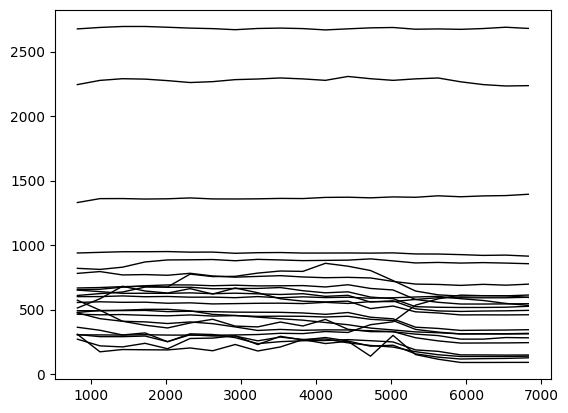

In [64]:
mean_fr_nl = (mean_fr-mean_fr_mode[:,np.newaxis])/mean_fr_mode[:,np.newaxis]
mean_fr_loc = 100*mean_fr_nl + location_y[:, np.newaxis]
plt.plot(time_long, mean_fr_loc[pass_qc].T, color = 'k', linewidth = 1);

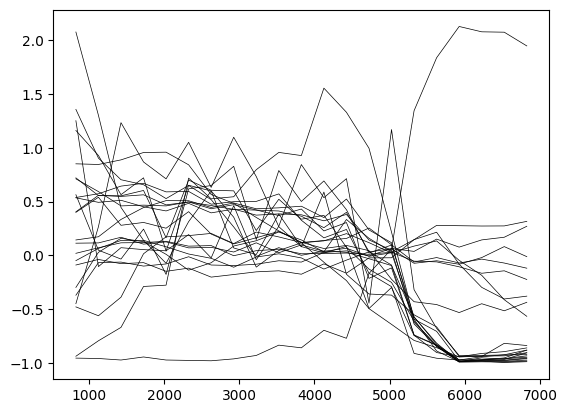

In [65]:
plt.plot(time_long, mean_fr_nl[pass_qc].T, color = 'k', linewidth = 0.5);

(-10.0, 10.0)

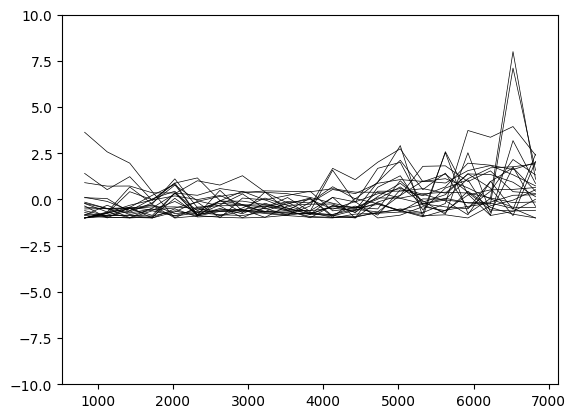

In [66]:
mean_amp_nl_mean = (mean_amp - np.nanmean(mean_amp,1)[:,np.newaxis])/np.nanmean(mean_amp,1)[:,np.newaxis]
mean_amp_nl_median = (mean_amp - mean_amp_mode[:,np.newaxis])/mean_amp_mode[:,np.newaxis]
plt.plot(time_long, mean_amp_nl_mean[pass_qc].T, color = 'k', linewidth = 0.5);
plt.ylim(-10, 10)

In [67]:
amp_loc_corr_session = []
amp_loc_corr_session_p = []
mean_amp_nl_mean = (mean_amp - np.nanmean(mean_amp,1)[:,np.newaxis])/np.nanmean(mean_amp,1)[:,np.newaxis]
mean_amp_nl_median = (mean_amp - mean_amp_mode[:,np.newaxis])/mean_amp_mode[:,np.newaxis]
mean_amp_nl = mean_amp_nl_mean
for unit_ind, unit_id in enumerate(unit_ids):
    mask = ~np.isnan(mean_amp_nl[unit_ind]) & ~np.isnan(mean_fr_nl[unit_ind])
    coeff, p_value = pearsonr(mean_amp_nl[unit_ind][mask], mean_fr_nl[unit_ind][mask])
    amp_loc_corr_session.append(coeff)
    amp_loc_corr_session_p.append(p_value)
amp_loc_corr_session = np.array(amp_loc_corr_session)
amp_loc_corr_session_p = np.array(amp_loc_corr_session_p)

Text(0.5, 1.0, '148 out of 243')

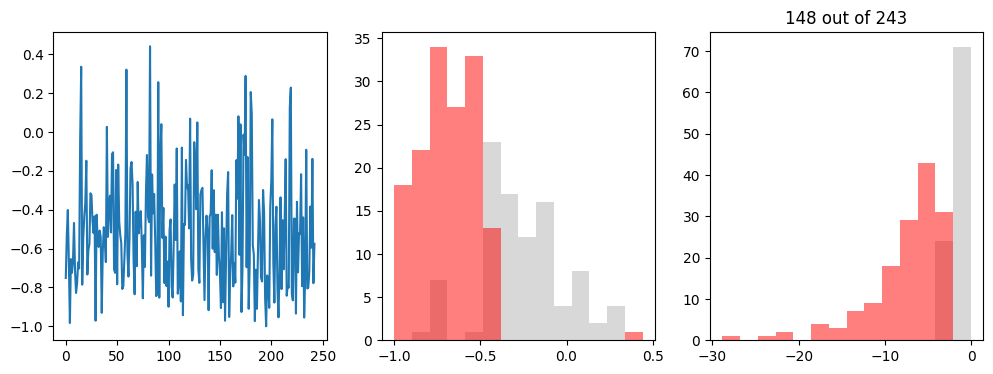

In [68]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(amp_loc_corr_session)

plt.subplot(1,3,2)
bins = np.linspace(np.min(amp_loc_corr_session)-0.001, np.max(amp_loc_corr_session)+0.001, 15)
plt.hist(amp_loc_corr_session[amp_loc_corr_session_p>0.05], bins = bins, facecolor = [0.7, 0.7, 0.7], alpha = 0.5)
plt.hist(amp_loc_corr_session[amp_loc_corr_session_p<0.05], bins = bins, facecolor = 'r', alpha = 0.5)

plt.subplot(1,3,3)
bins = np.linspace(np.min(np.log(amp_loc_corr_session_p))-0.001, np.max(np.log(amp_loc_corr_session_p))+0.001, 15)
plt.hist(np.log(amp_loc_corr_session_p)[amp_loc_corr_session_p>0.05], bins = bins, facecolor = [0.7, 0.7, 0.7], alpha = 0.5)
plt.hist(np.log(amp_loc_corr_session_p)[amp_loc_corr_session_p<0.05], bins = bins, facecolor = 'r', alpha = 0.5)
plt.title(f"{np.sum(amp_loc_corr_session_p<0.05)} out of {len(amp_loc_corr_session_p)}")

In [69]:
# curr_ind = 1
# fig = plt.figure(figsize=(20, 12))
# for unit_ind, unit_id in enumerate(unit_ids):
#     if amp_loc_corr_session_p[unit_ind]<0.05 and pass_qc[unit_ind]:
#         plt.subplot(9,6,curr_ind)
#         curr_ind += 1
#         plt.plot(time_long, mean_amp_nl[unit_ind], color = 'b')
#         # plt.plot(time_long, np.abs(mean_amp_nl[unit_ind]), color = 'k')
#         plt.plot(time_long, mean_fr_nl[unit_ind], color = 'r')
#         plt.title(f"{amp_loc_corr_session[unit_ind]:.2} p={amp_loc_corr_session_p[unit_ind]:.2}")
# plt.tight_layout()
    

In [70]:
# # test and training data
# # plot significant units
# curr_ind = 1
# fig = plt.figure(figsize=(20, 12))
# for unit_ind, unit_id in enumerate(unit_ids):
#     if amp_loc_corr_session_p[unit_ind]<0.05 and pass_qc[unit_ind]:
#         plt.subplot(9,6,curr_ind)
#         curr_ind += 1
#         plt.plot(time_long_test, fr_test[unit_ind], color = 'b')
#         # plt.plot(time_long, np.abs(mean_amp_nl[unit_ind]), color = 'k')
#         plt.plot(time_long_test, pred_test[unit_ind], color = 'r')
#         plt.title(f"R2 = {R2_test[unit_ind]:.2f} Amp_cutoff = {qm['amplitude_cutoff'][unit_id]:.2f}") 
# plt.suptitle('Test data, sig corr')
# plt.tight_layout()

# curr_ind = 1
# fig = plt.figure(figsize=(20, 12))
# for unit_ind, unit_id in enumerate(unit_ids):
#     if amp_loc_corr_session_p[unit_ind]<0.05 and pass_qc[unit_ind]:
#         plt.subplot(9,6,curr_ind)
#         curr_ind += 1
#         plt.plot(time_long_train, fr_train[unit_ind], color = 'b')
#         # plt.plot(time_long, np.abs(mean_amp_nl[unit_ind]), color = 'k')
#         plt.plot(time_long_train, pred_train[unit_ind], color = 'r')
#         plt.title(f"R2 = {R2_train[unit_ind]:.2f} Amp_cutoff = {qm['amplitude_cutoff'][unit_id]:.2f}")
# plt.suptitle('Train data, sig corr')
# plt.tight_layout()

    

In [71]:
# curr_ind = 1
# fig = plt.figure(figsize=(20, 12))
# for unit_ind, unit_id in enumerate(unit_ids):
#     if amp_loc_corr_session_p[unit_ind]>0.05 and pass_qc[unit_ind]:
#         plt.subplot(7,6,curr_ind)
#         curr_ind += 1
#         plt.plot(time_long, mean_amp_nl[unit_ind], color = 'b')
#         # plt.plot(mean_amp[unit_ind], color = 'b')
#         # plt.plot(np.abs(mean_amp_nl[unit_ind]), color = 'k')
#         plt.plot(time_long, mean_fr_nl[unit_ind], color = 'r')
#         plt.title(f"{amp_loc_corr_session[unit_ind]:.2} p={amp_loc_corr_session_p[unit_ind]:.2}")
# plt.tight_layout()

In [72]:
# # plot not significant units
# curr_ind = 1
# fig = plt.figure(figsize=(20, 12))
# for unit_ind, unit_id in enumerate(unit_ids):
#     if amp_loc_corr_session_p[unit_ind]>0.05 and pass_qc[unit_ind]:
#         plt.subplot(9,6,curr_ind)
#         curr_ind += 1
#         plt.plot(time_long_test, fr_test[unit_ind], color = 'b')
#         # plt.plot(time_long, np.abs(mean_amp_nl[unit_ind]), color = 'k')
#         plt.plot(time_long_test, pred_test[unit_ind], color = 'r')
#         plt.title(f'R2 = {R2_test[unit_ind]:.2} Amp_cutoff = {qm["amplitude_cutoff"][unit_id]:.2f}')
# plt.suptitle('Test data, no sig corr')
# plt.tight_layout()

# curr_ind = 1
# fig = plt.figure(figsize=(20, 12))
# for unit_ind, unit_id in enumerate(unit_ids):
#     if amp_loc_corr_session_p[unit_ind]>0.05 and pass_qc[unit_ind]:
#         plt.subplot(9,6,curr_ind)
#         curr_ind += 1
#         plt.plot(time_long_train, fr_train[unit_ind], color = 'b')
#         # plt.plot(time_long, np.abs(mean_amp_nl[unit_ind]), color = 'k')
#         plt.plot(time_long_train, pred_train[unit_ind], color = 'r')
#         plt.title(f'R2 = {R2_train[unit_ind]:.2} Amp_cutoff = {qm["amplitude_cutoff"][unit_id]:.2f}')
# plt.suptitle('Train data, no sig corr')
# plt.tight_layout()

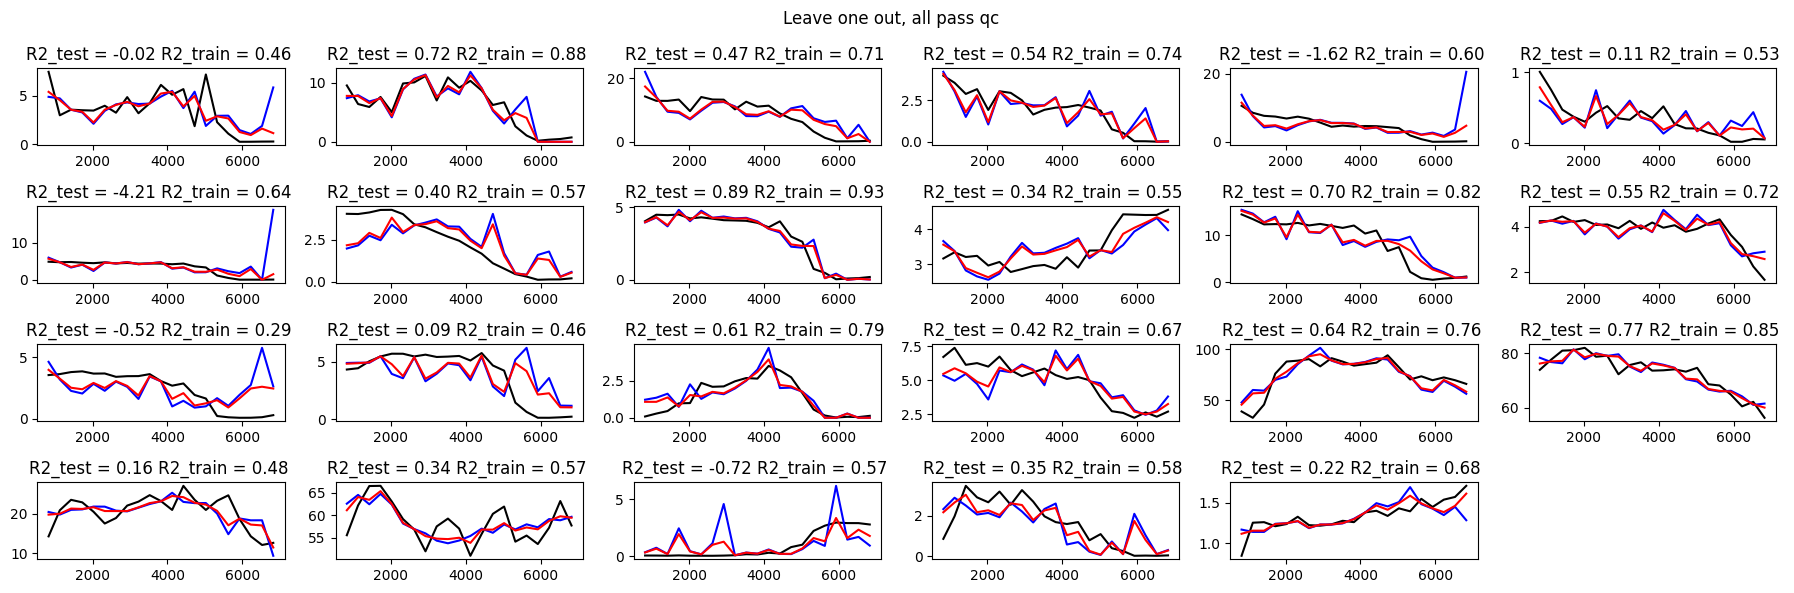

In [73]:
# Leave one out
# plot all pass qc
curr_ind = 1
fig = plt.figure(figsize=(18, 1.5*np.ceil(np.sum(pass_qc)/6)))
for unit_ind, unit_id in enumerate(unit_ids):
    if pass_qc[unit_ind]:
        plt.subplot(int(np.ceil(np.sum(pass_qc)/6)),6,curr_ind)
        curr_ind += 1
        plt.plot(time_long, mean_fr[unit_ind], color = 'k')
        plt.plot(time_long, pred_test[unit_ind], color = 'b')
        plt.plot(time_long, pred_train[unit_ind], color = 'r')
        plt.title(f"R2_test = {R2_test[unit_ind]:.2f} R2_train = {R2_train[unit_ind]:.2f} ") 
plt.suptitle('Leave one out, all pass qc')
plt.tight_layout()
fig.savefig(f'/root/capsule/scratch/features/{session}/singlefit_all_pass_qc.png')

In [74]:
Normalize by sample variance

NameError: name 'sess' is not defined

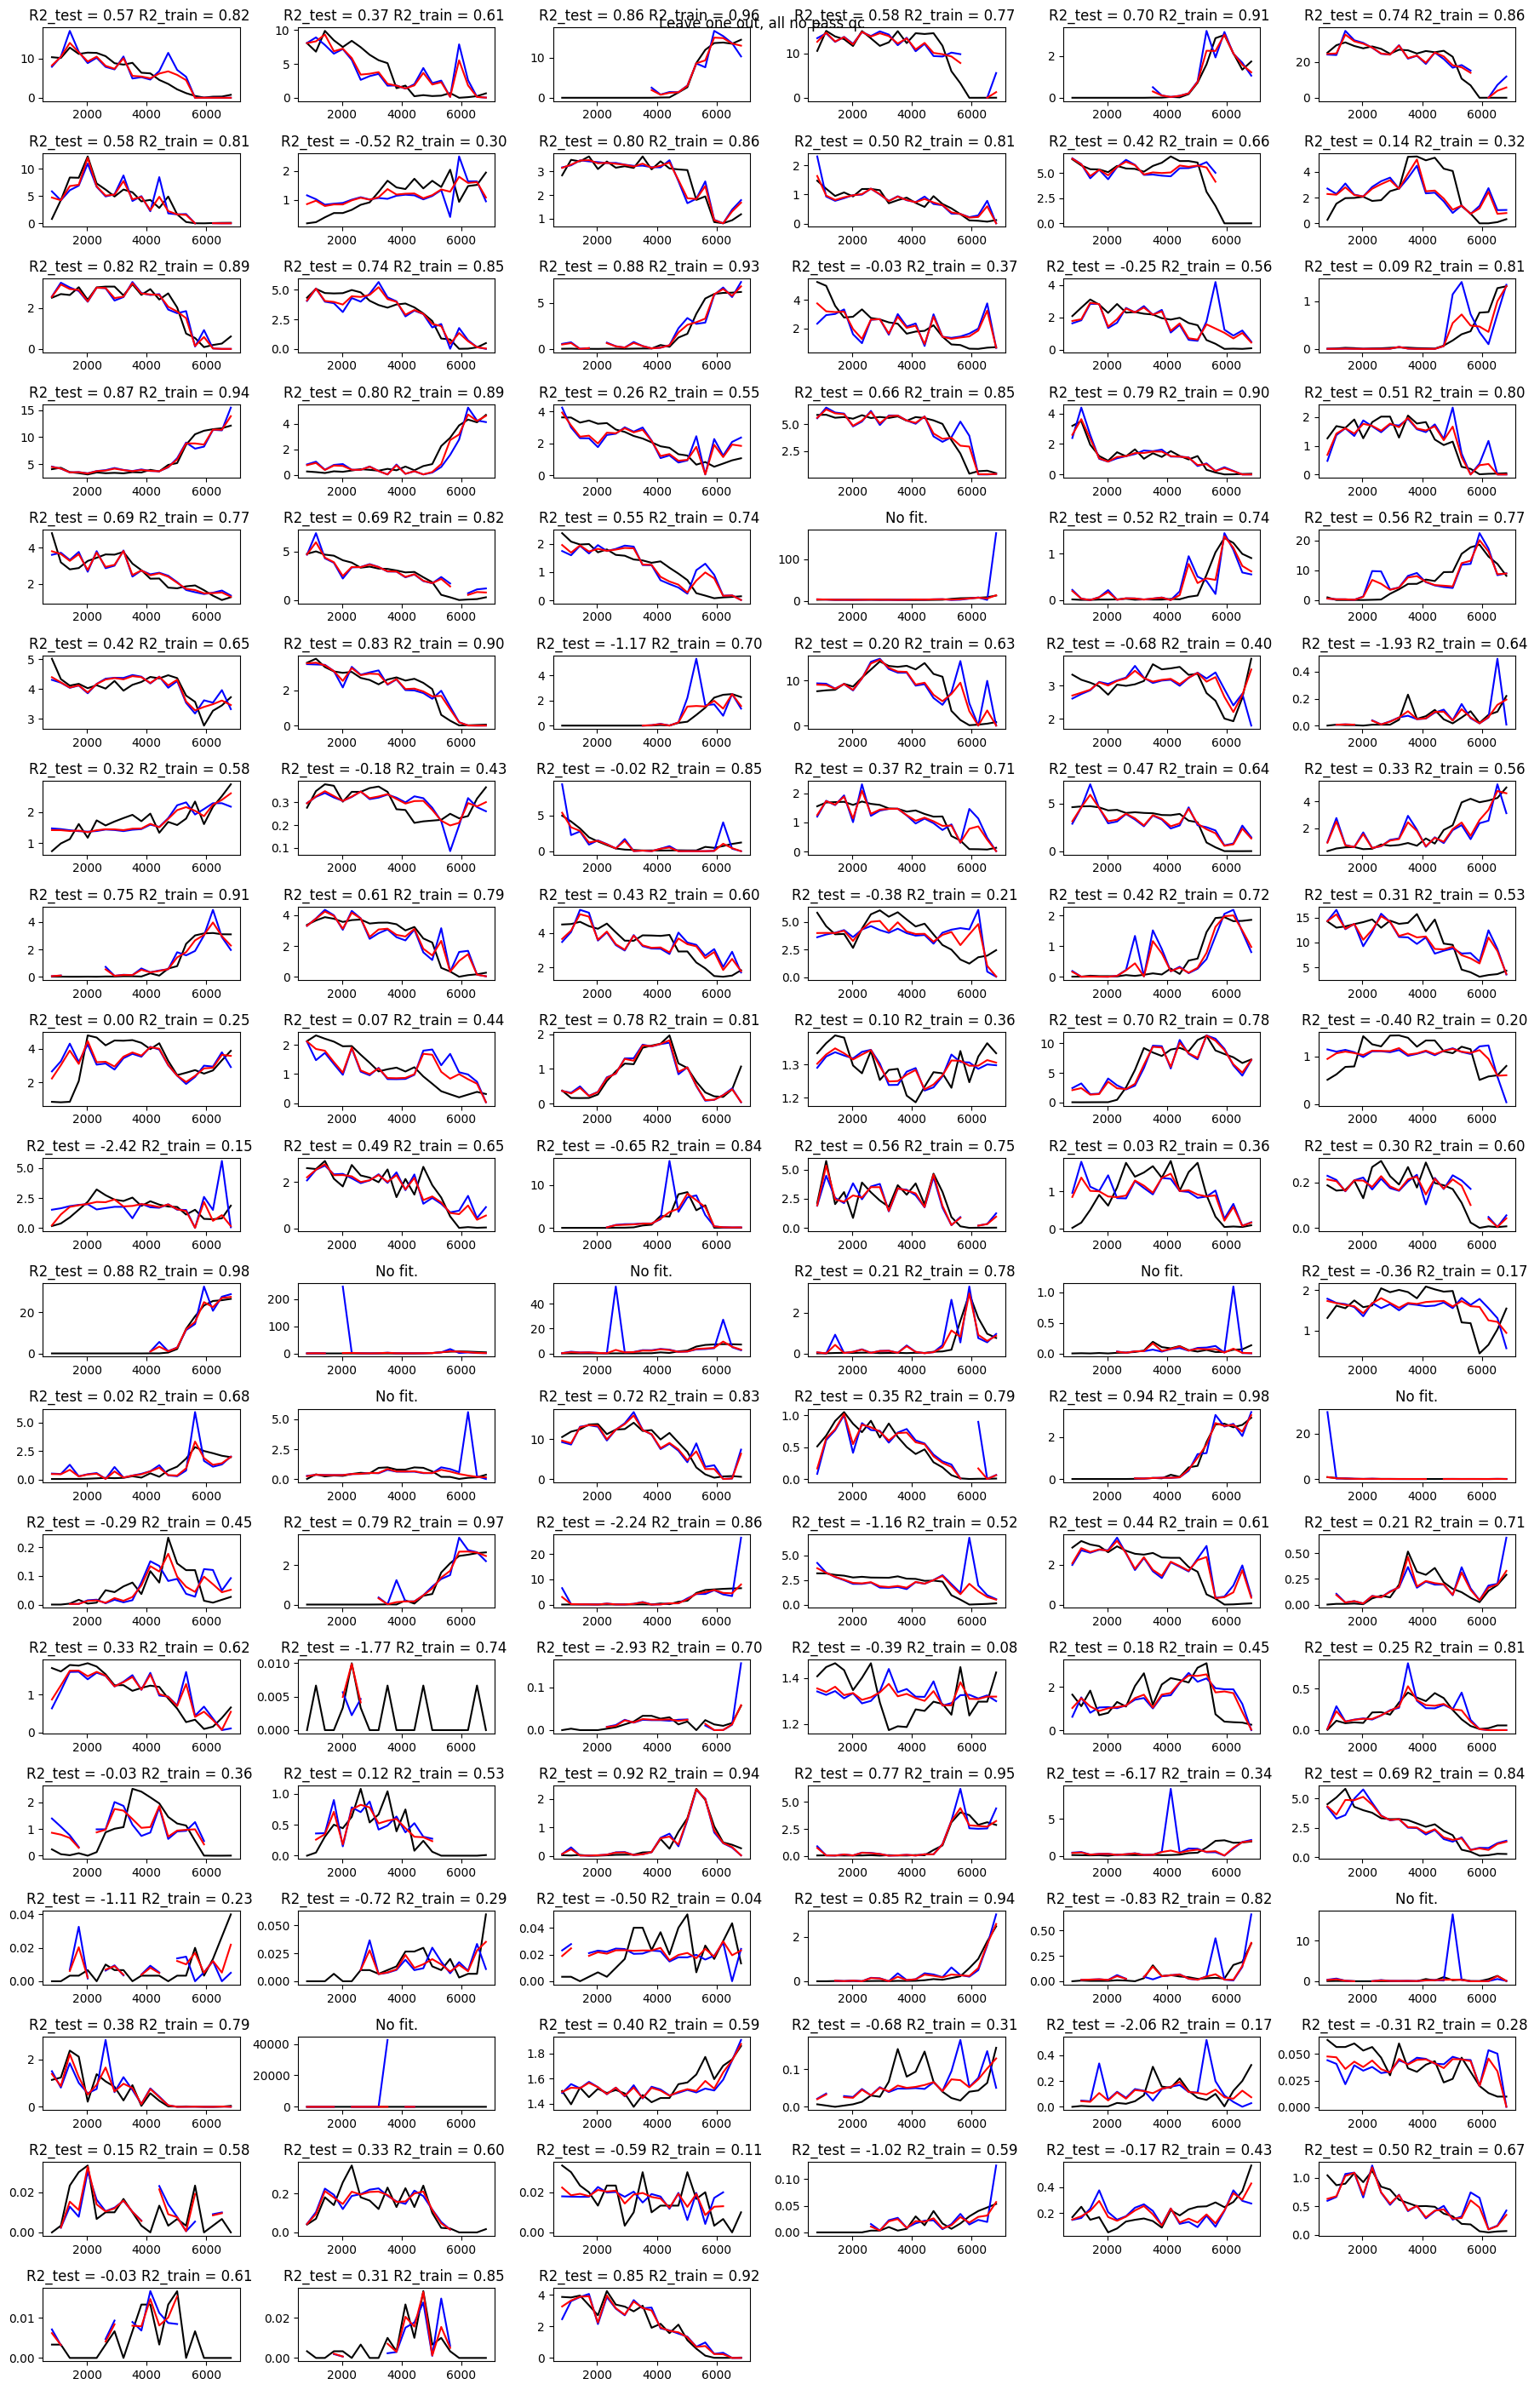

In [ ]:
# Leave one out
# plot all no pass qc
curr_ind = 1
fig = plt.figure(figsize=(18, 1.5*np.ceil(np.sum(~pass_qc & pass_real)/6)))
for unit_ind, unit_id in enumerate(unit_ids):
    if (not pass_qc[unit_ind]) and pass_real[unit_ind]:
        plt.subplot(int(np.ceil(np.sum(~pass_qc & pass_real)/6)),6,curr_ind)
        curr_ind += 1
        plt.plot(time_long, mean_fr[unit_ind], color = 'k')
        plt.plot(time_long, pred_test[unit_ind], color = 'b')
        plt.plot(time_long, pred_train[unit_ind], color = 'r')
        if R2_test[unit_ind]>-10:
            plt.title(f"R2_test = {R2_test[unit_ind]:.2f} R2_train = {R2_train[unit_ind]:.2f} ") 
        else:
            plt.title(f"No fit.")
plt.suptitle('Leave one out, all no pass qc')
plt.tight_layout()
fig.savefig(fname = f'/root/capsule/scratch/features/{session}/singlefit_all_real_no_pass_qc.png')

(array([0.        , 0.10326087, 0.20652174, 0.30978261, 0.20652174,
        0.30978261, 0.30978261, 0.30978261, 0.        , 0.72282609,
        0.61956522, 0.61956522, 0.92934783, 0.92934783, 1.0326087 ,
        0.30978261, 1.23913043, 1.13586957, 0.20652174]),
 array([-1.        , -0.89473684, -0.78947368, -0.68421053, -0.57894737,
        -0.47368421, -0.36842105, -0.26315789, -0.15789474, -0.05263158,
         0.05263158,  0.15789474,  0.26315789,  0.36842105,  0.47368421,
         0.57894737,  0.68421053,  0.78947368,  0.89473684,  1.        ]),
 <BarContainer object of 19 artists>)

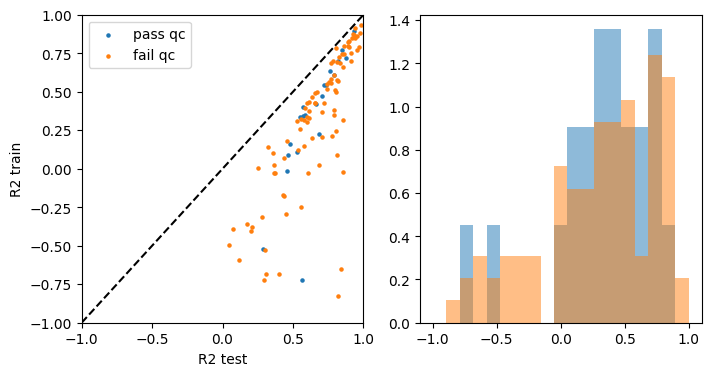

In [ ]:
fig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
R2_test = np.array(R2_test)
R2_train = np.array(R2_train)
# R2_test[R2_test<0] = 0
# R2_train[R2_train<0] = 0
plt.scatter(R2_train[pass_qc], R2_test[pass_qc], s = 5, label = 'pass qc');
plt.scatter(R2_train[~pass_qc &  pass_real], R2_test[~pass_qc & pass_real],  s = 5, label = 'fail qc');
plt.plot([-1,1], [-1,1], color = 'k', linestyle = '--')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('R2 test')
plt.ylabel('R2 train')
plt.legend()
plt.subplot(1,2,2)
plt.hist(R2_test[pass_qc], bins = np.linspace(-1, 1, 20), alpha = 0.5, density=True, label = 'pass qc')
plt.hist(R2_test[~pass_qc&pass_real], bins = np.linspace(-1, 1, 20), alpha = 0.5, density=True, label = 'fail qc')
fig.savefig(fname = f'/root/capsule/scratch/features/{session}/R2_compare_passornot.png')


In [ ]:

# data = {'R2_train': R2_train, 
#         'R2_test': R2_test,  
#         'pass_qc': pass_qc, 
#         'amplitude_cutoff': qm['amplitude_cutoff'].values, 
#         'amp_loc_corr': np.abs(amp_loc_corr_session),
#         'drift_ptp': qm['drift_ptp'].values,
#         'drift_std': qm['drift_std'].values,
#         'drift_mad': qm['drift_mad'].values}
# data = pd.DataFrame(data,index = unit_ids)
# sns.pairplot(data[pass_qc], diag_kind = 'kde', plot_kws = {'alpha': 0.5, 's': 10})

In [ ]:
# # detect drift by firing rate and amplitude into a small time scale
# amps = we.load_extension("spike_amplitudes").get_data(outputs="by_unit")[0]
# locations = we.load_extension('unit_locations').get_data(outputs="by_unit")
# num_peak_channels = 2
# num_peak_pc = 1

# bin_size = 1000
# sub_bin_size = 50
# bin_step = 100
# bin_start = np.arange(timestamps[0], timestamps[-1]-bin_size, bin_step)
# bin_end = bin_start + bin_size
# time_short = 0.5 * (bin_start + bin_end)

# R2_allUnits = []
# for unit_ind, unit_id in enumerate(unit_ids):
#     timestamps_curr = timestamps[sorting.get_unit_spike_train(unit_id)]
#     amplitude_curr = amps[unit_id]
    
#     # load pcs
#     pcs = get_features(unit_id, pc_feature, spike_clusters)
#     pcs = pcs.reshape(pcs.shape[0], -1)
#     pcs_median = np.median(pcs, axis=0)
#     pcs = np.abs(pcs - pcs_median)
    
#     R2_train_curr = []

    
#     for bin_ind in range(len(bin_start)):
#         fr_mean_temp = []
#         amp_mean_temp = []
#         pc_mean_temp = []
#         # R2 in each bin
#         if np.sum((timestamps_curr >= bin_start[bin_ind]) & (timestamps_curr < bin_end[bin_ind]))>0:
#             timestamps_sub_curr = timestamps_curr[(timestamps_curr >= bin_start[bin_ind]) & (timestamps_curr < bin_end[bin_ind])]
#             amplitude_sub_curr = amplitude_curr[(timestamps_curr >= bin_start[bin_ind]) & (timestamps_curr < bin_end[bin_ind])]
#             pc_sub_curr = pcs[(timestamps_curr >= bin_start[bin_ind]) & (timestamps_curr < bin_end[bin_ind])]
#             bins_sub = np.arange(bin_start[bin_ind], bin_end[bin_ind], sub_bin_size)
#             # divide in sub-bins
#             sub_bins_indices = np.digitize(timestamps_sub_curr, bins_sub)
#             for sub_bin_ind in range(len(bins_sub)-1):
#                 fr_mean_temp.append(np.sum(sub_bins_indices==(sub_bin_ind+1))/sub_bin_size)
#                 if np.sum(sub_bins_indices==(sub_bin_ind+1)) == 0:
#                     amp_mean_temp.append(np.nan)
#                     pc_mean_temp.append(np.full(pcs.shape[1], np.nan))
#                 else:
#                     amp_mean_temp.append(np.mean(amplitude_sub_curr[sub_bins_indices==(sub_bin_ind+1)]))
#                     pc_mean_temp.append(np.mean(pc_sub_curr[sub_bins_indices==(sub_bin_ind+1)], axis=0))
#             # fit linear model on training data on big bin
#             mask = ~np.isnan(amp_mean_temp) & ~np.isnan(fr_mean_temp)
#             if np.sum(mask)>1:
#                 lm = LinearRegression()
#                 x_matrix = np.array(pc_mean_temp)
#                 lm.fit(x_matrix[mask], np.array(fr_mean_temp)[mask])
#                 # predict training data
#                 pred = lm.predict(x_matrix[mask])
#                 R2_train_curr.append(r2_score(np.array(fr_mean_temp)[mask], pred))
#             else:
#                 # not enough data
#                 R2_train_curr.append(np.nan)
#         else:
#             # no spikes in the bin
#             R2_train_curr.append(np.nan)
    
#     R2_allUnits.append(R2_train_curr)

# R2_allUnits = np.array(R2_allUnits)


In [ ]:
#GLM detect drift by firing rate and amplitude into a small time scale
amps = we.load_extension("spike_amplitudes").get_data(outputs="by_unit")[0]
locations = we.load_extension('unit_locations').get_data(outputs="by_unit")
num_peak_channels = 2
num_peak_pc = 1

bin_size = 1000
sub_bin_size = 50
bin_step = 100
bin_start = np.arange(timestamps[0], timestamps[-1]-bin_size, bin_step)
bin_end = bin_start + bin_size
time_short = 0.5 * (bin_start + bin_end)

R2_allUnits = []
for unit_ind, unit_id in enumerate(unit_ids):
    timestamps_curr = timestamps[sorting.get_unit_spike_train(unit_id)]
    amplitude_curr = amps[unit_id]
    
    # load pcs
    pcs = get_features(unit_id, pc_feature, spike_clusters)
    pcs = pcs.reshape(pcs.shape[0], -1)
    pcs_median = np.median(pcs, axis=0)
    # pcs = np.abs(pcs - pcs_median)
    
    R2_train_curr = []

    
    for bin_ind in range(len(bin_start)):
        fr_mean_temp = []
        amp_mean_temp = []
        pc_mean_temp = []
        # R2 in each bin
        if np.sum((timestamps_curr >= bin_start[bin_ind]) & (timestamps_curr < bin_end[bin_ind]))>0:
            timestamps_sub_curr = timestamps_curr[(timestamps_curr >= bin_start[bin_ind]) & (timestamps_curr < bin_end[bin_ind])]
            amplitude_sub_curr = amplitude_curr[(timestamps_curr >= bin_start[bin_ind]) & (timestamps_curr < bin_end[bin_ind])]
            pc_sub_curr = pcs[(timestamps_curr >= bin_start[bin_ind]) & (timestamps_curr < bin_end[bin_ind])]
            bins_sub = np.arange(bin_start[bin_ind], bin_end[bin_ind], sub_bin_size)
            # divide in sub-bins
            sub_bins_indices = np.digitize(timestamps_sub_curr, bins_sub)
            for sub_bin_ind in range(len(bins_sub)-1):
                fr_mean_temp.append(np.sum(sub_bins_indices==(sub_bin_ind+1))/sub_bin_size)
                if np.sum(sub_bins_indices==(sub_bin_ind+1)) == 0:
                    amp_mean_temp.append(np.nan)
                    pc_mean_temp.append(np.full(pcs.shape[1], np.nan))
                else:
                    amp_mean_temp.append(np.mean(amplitude_sub_curr[sub_bins_indices==(sub_bin_ind+1)]))
                    pc_mean_temp.append(np.mean(pc_sub_curr[sub_bins_indices==(sub_bin_ind+1)], axis=0))
            # center on max firing rate bin
            amp_mean_temp = np.array(amp_mean_temp)
            pc_mean_temp = np.array(pc_mean_temp)
            fr_mean_temp = np.array(fr_mean_temp)
            max_ind = np.argmax(np.array(fr_mean_temp))
            amp_center = amp_mean_temp[max_ind]
            pc_center = pc_mean_temp[max_ind]

            amp_mean_temp = np.abs(amp_mean_temp - amp_center)
            pc_mean_temp = np.abs(pc_mean_temp - pc_center)

            # fit glm on training data on big bin
            mask = ~np.isnan(amp_mean_temp)
            if np.sum(mask)>12 and len(np.unique(fr_mean_temp[mask]))>2:
                x_matrix = pc_mean_temp
                x_matrix = sm.add_constant(x_matrix)
                glm_model = sm.GLM(fr_mean_temp[mask], x_matrix[mask], family=Gaussian(link=Log()))
                glm_results = glm_model.fit()
                # predict training data
                fr_pred_clean = glm_results.predict(x_matrix[mask])
                R2_train_curr.append(r2_score(fr_mean_temp[mask], fr_pred_clean))
            else:
                # not enough data
                R2_train_curr.append(np.nan)
        else:
            # no spikes in the bin
            R2_train_curr.append(np.nan)
    
    R2_allUnits.append(R2_train_curr)

R2_allUnits = np.array(R2_allUnits)


Text(0.5, 1.0, 'All good units')

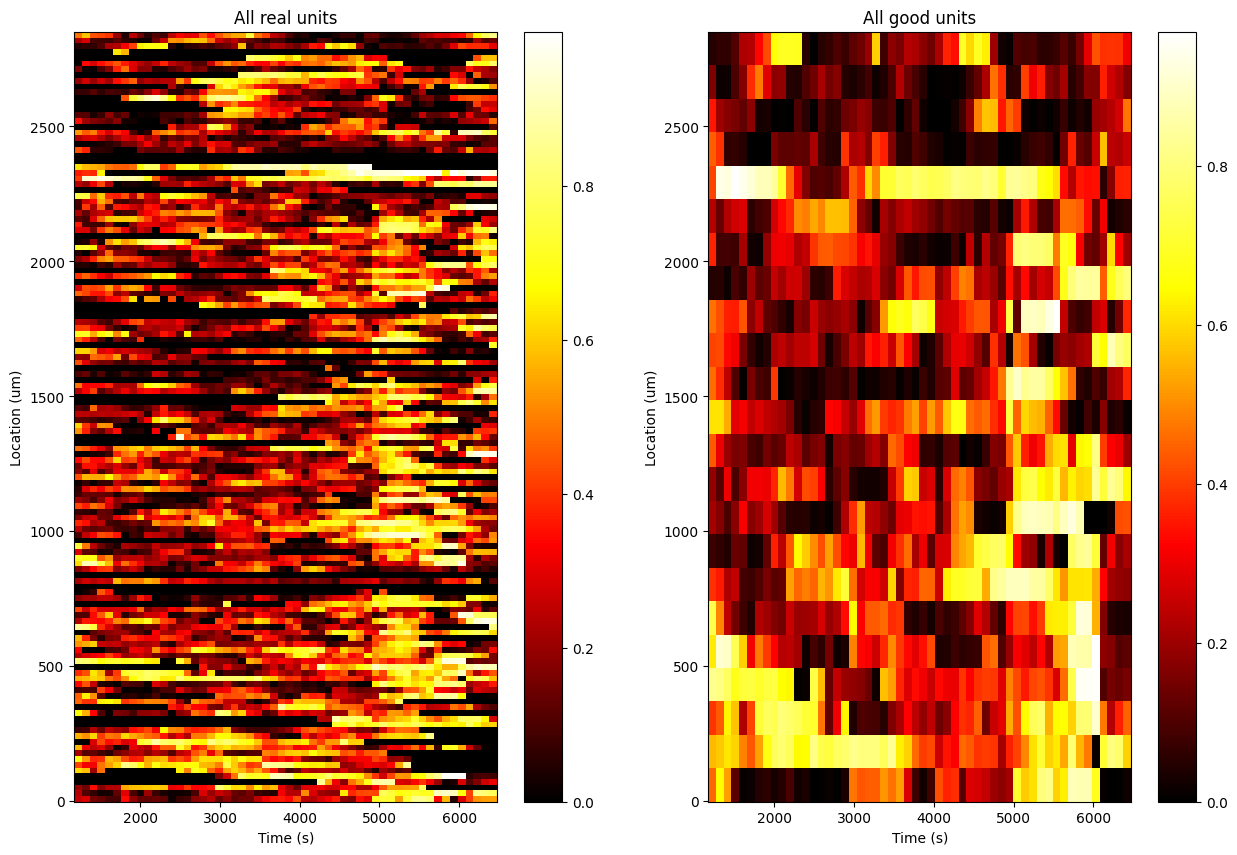

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
fire_colors = [
    (0.0, 0.0, 0.0),  # black
    (1.0, 0.0, 0.0),  # red
    (1.0, 1.0, 0.0),  # yellow
    (1.0, 1.0, 1.0)   # white
]
y_ind = np.argsort(location_y)[::-1]
fire_cmap = LinearSegmentedColormap.from_list("fire", fire_colors)
fig = plt.figure(figsize=(15, 10))
# all real units
plt.subplot(1,2,1)
R2_allUnits = np.array(R2_allUnits)
R2_allUnits_clean = R2_allUnits.copy()
R2_allUnits_clean[R2_allUnits<0] = 0
R2_allUnits_clean[np.isnan(R2_allUnits)] = 0
R2_allUnits_clean_y = R2_allUnits_clean[y_ind]
plt.imshow(R2_allUnits_clean_y[pass_real[y_ind]], extent = [time_short[0], time_short[-1], np.min(location_y), np.max(location_y)], cmap=fire_cmap, aspect='auto')
plt.xlabel('Time (s)')
plt.ylabel('Location (um)')
plt.colorbar()
plt.title('All real units')
# plt.subplot(1,2,2)
# plt.imshow(corr_allUnits_p[pass_qc]<0.05)
# # plt.colorbar()

# all good units
plt.subplot(1,2,2)
plt.imshow(R2_allUnits_clean_y[pass_qc[y_ind]], extent = [time_short[0], time_short[-1], np.min(location_y), np.max(location_y)], cmap=fire_cmap, aspect='auto')
plt.xlabel('Time (s)')
plt.ylabel('Location (um)')
plt.colorbar()
plt.title('All good units')


In [ ]:
# smoothed version 
R2_allUnits_clean_smooth = R2_allUnits_clean.copy()
for row_ind in range(np.shape(R2_allUnits_clean)[0]):
    for col_ind in range(np.shape(R2_allUnits_clean)[1]):
        curr_ele = R2_allUnits_clean[row_ind, col_ind]
        left_neigh = R2_allUnits_clean[row_ind, max(0, col_ind-1)]
        right_neigh = R2_allUnits_clean[row_ind, min(np.shape(R2_allUnits_clean)[1]-1, col_ind+1)]
        if curr_ele >= 0.5 and curr_ele - left_neigh > 0.3 and curr_ele - right_neigh > 0.3: 
            curr_ele = np.nanmean(np.array([left_neigh, right_neigh]))
        R2_allUnits_clean_smooth[row_ind, col_ind] = np.mean(R2_allUnits_clean[max(0, row_ind-1):min(np.shape(R2_allUnits_clean)[0], row_ind+2), col_ind])
R2_allUnits_smooth = R2_allUnits_clean_smooth.copy()
R2_allUnits_smooth[np.isnan(R2_allUnits)] = np.nan
R2_allUnits_smooth[R2_allUnits<-1] = 0

Text(0.5, 1.0, 'All good units')

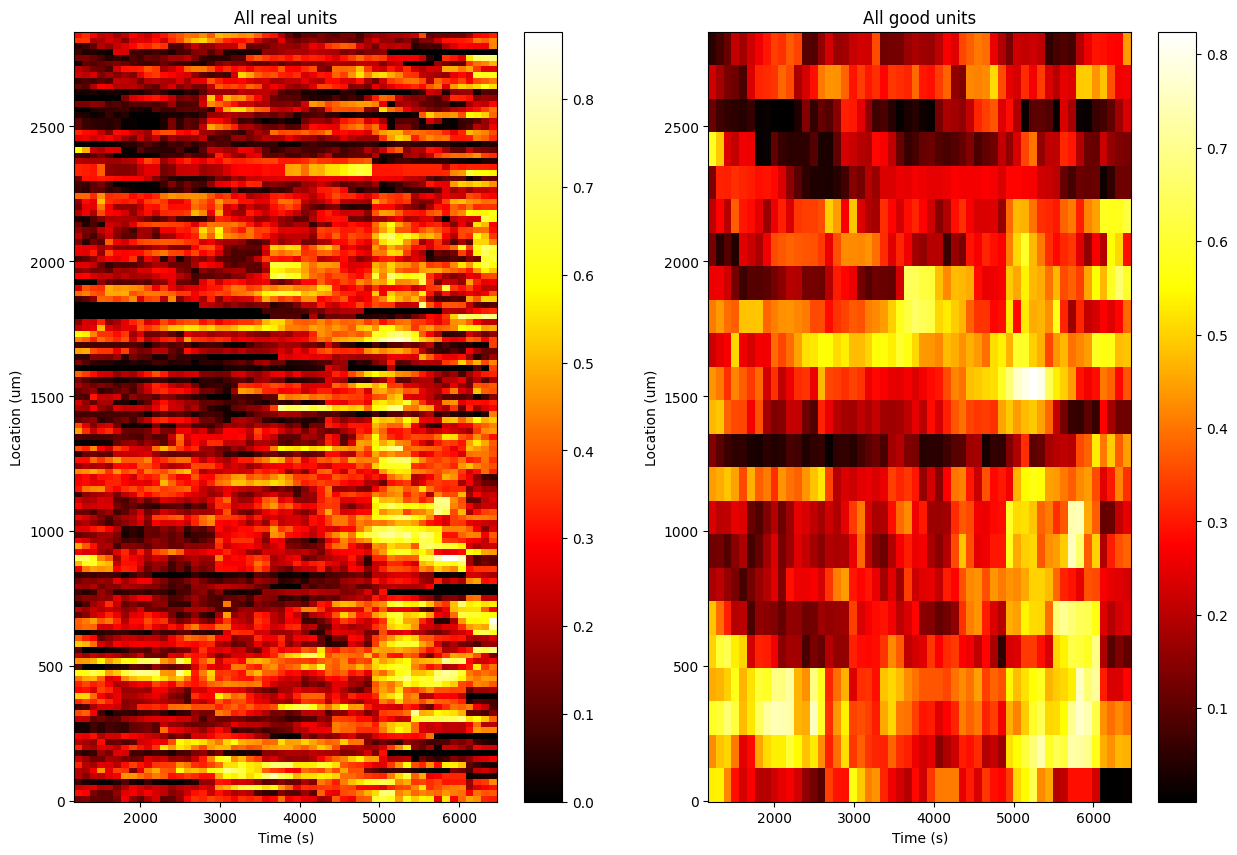

In [ ]:
# smoothed version
from matplotlib.colors import LinearSegmentedColormap
fire_colors = [
    (0.0, 0.0, 0.0),  # black
    (1.0, 0.0, 0.0),  # red
    (1.0, 1.0, 0.0),  # yellow
    (1.0, 1.0, 1.0)   # white
]
y_ind = np.argsort(location_y)[::-1]
fire_cmap = LinearSegmentedColormap.from_list("fire", fire_colors)
fig = plt.figure(figsize=(15, 10))
# all real units
plt.subplot(1,2,1)
R2_allUnits_clean_y_smooth = R2_allUnits_clean_smooth[y_ind]
plt.imshow(R2_allUnits_clean_y_smooth[pass_real[y_ind]], extent = [time_short[0], time_short[-1], np.min(location_y), np.max(location_y)], cmap=fire_cmap, aspect='auto')
plt.xlabel('Time (s)')
plt.ylabel('Location (um)')
plt.colorbar()
plt.title('All real units')
# plt.subplot(1,2,2)
# plt.imshow(corr_allUnits_p[pass_qc]<0.05)
# # plt.colorbar()

# all good units
plt.subplot(1,2,2)
plt.imshow(R2_allUnits_clean_y_smooth[pass_qc[y_ind]], extent = [time_short[0], time_short[-1], np.min(location_y), np.max(location_y)], cmap=fire_cmap, aspect='auto')
plt.xlabel('Time (s)')
plt.ylabel('Location (um)')
plt.colorbar()
plt.title('All good units')
fig.savefig(fname = f'/root/capsule/scratch/features/{session}/R2_spatial_heatmap.png')

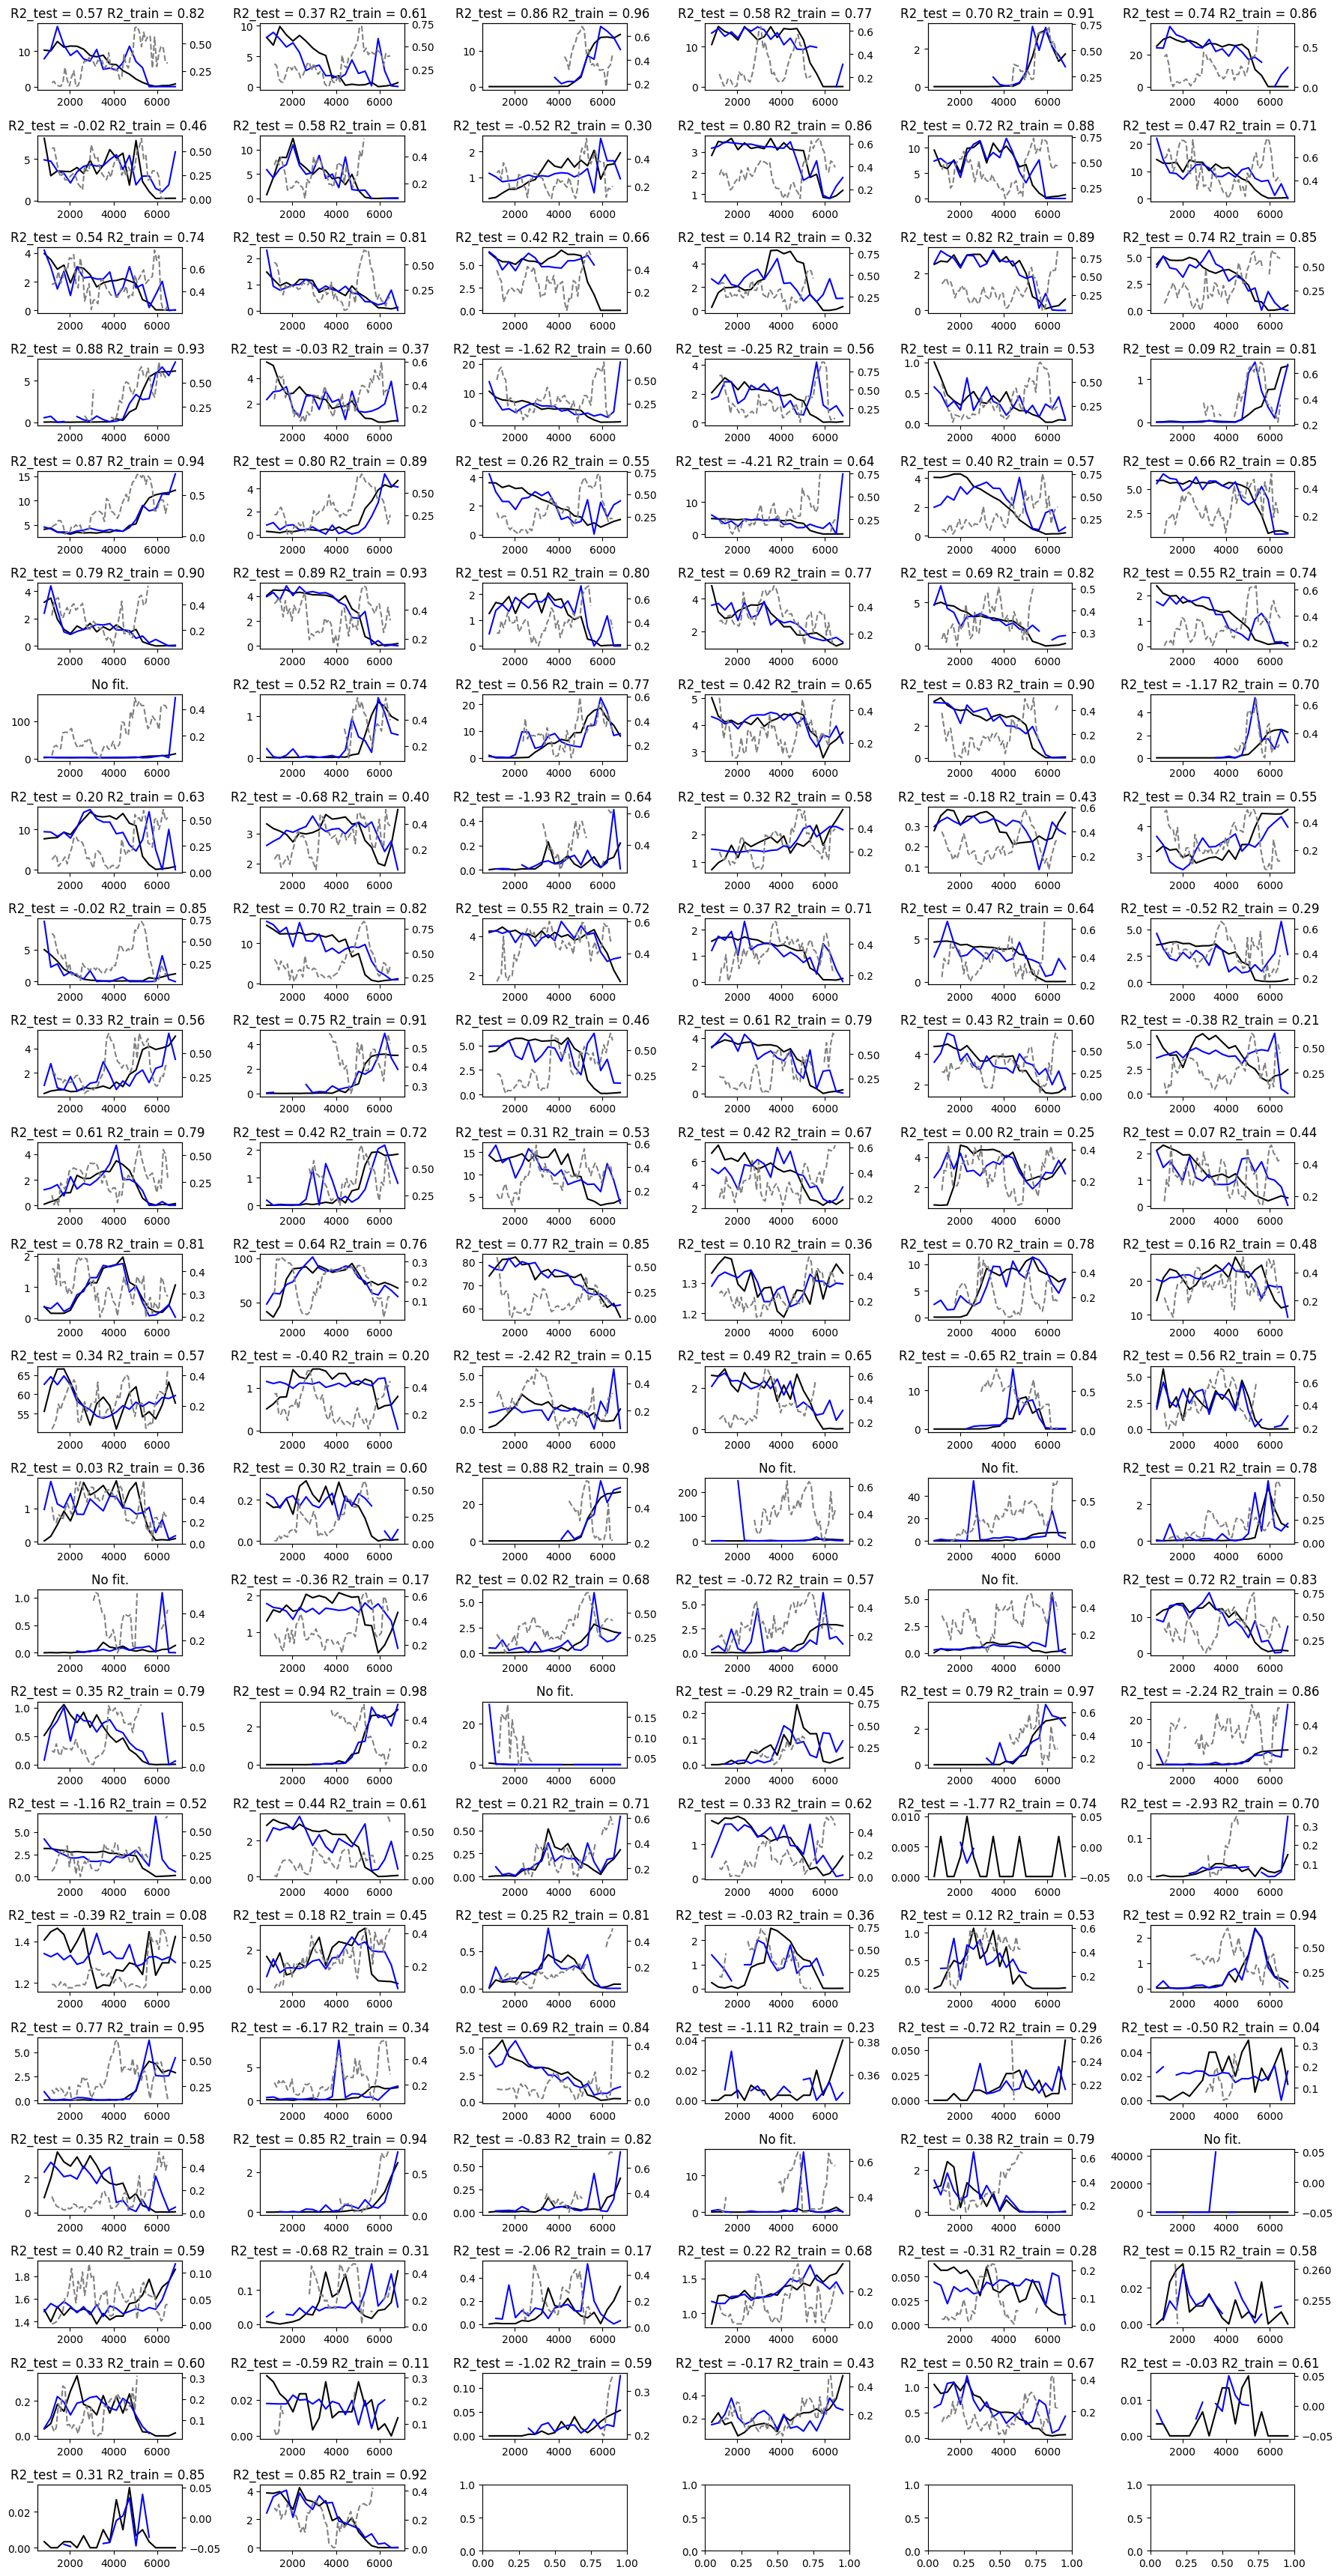

In [ ]:
curr_ind = 0
fig, axes = plt.subplots(int(np.ceil(np.sum(pass_real)/6)),6, figsize=(18, 1.5*np.ceil(np.sum(pass_real)/6)))
for unit_ind, unit_id in enumerate(unit_ids):
    if pass_real[unit_ind]:
        ax = axes[curr_ind//6, curr_ind%6]
        axt = ax.twinx()
        axt.plot(time_short, R2_allUnits_smooth[unit_ind], color = [0.5, 0.5, 0.5], ls = '--')
        ax.plot(time_long, mean_fr[unit_ind], color = 'k')
        ax.plot(time_long, pred_test[unit_ind], color = 'b')
        # plt.plot(time_short[corr_allUnits_p[unit_ind]<0.01], np.ones_like(time_short[corr_allUnits_p[unit_ind]<0.01]), color = 'k')
        if R2_test[unit_ind]>-10:
            ax.set_title(f"R2_test = {R2_test[unit_ind]:.2f} R2_train = {R2_train[unit_ind]:.2f} ")
        else:
            plt.title("No fit.")
        curr_ind += 1
plt.tight_layout()
fig.savefig(fname = f'/root/capsule/scratch/features/{session}/all_real_units_fit_sliding.png')
    

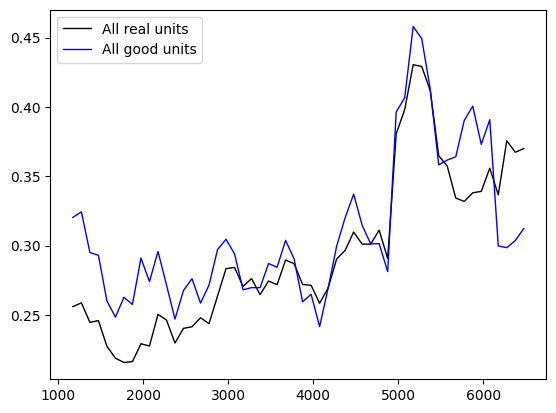

In [ ]:
fig = plt.figure(figsize=(4,4))
plt.plot(time_short, np.nanmean(R2_allUnits_smooth[pass_real], 0), color = 'k', linewidth = 1, label = 'All real units');
plt.plot(time_short, np.nanmean(R2_allUnits_smooth[pass_qc], 0), color = 'b', linewidth = 1, label = 'All good units');
plt.legend()
plt.xlabel('Time (s)')
plot.ylabel('R2')
fig.savefig(fname = f'/root/capsule/scratch/features/{session}/R2_pop_mean.png')